# Phase 4 project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix


nltk.download('wordnet')


%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\josec\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':200})
plt.style.use('ggplot')

In [3]:
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [4]:
## First look at the data
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Change the column names so it can be more readable
data.columns = ['tweet', 'product', 'sentiment']

In [6]:
## Much cleaner
data.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
## Quick look at our target values
data.sentiment.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [8]:
## Change it so its now positive, negative or neutral
data['sentiment'].replace({'No emotion toward brand or product' : 'Neutral emotion', '''I can't tell''' : 'Neutral emotion'},
                         inplace=True)

In [9]:
data['sentiment'].value_counts()

Neutral emotion     5545
Positive emotion    2978
Negative emotion     570
Name: sentiment, dtype: int64

In [10]:
## Dropping all rows with Null values in it
data = data.dropna(axis=0)

In [11]:
## Reset index for aesthetics 
data.reset_index(drop=True, inplace=True)

In [12]:
data['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

## Quick EDA

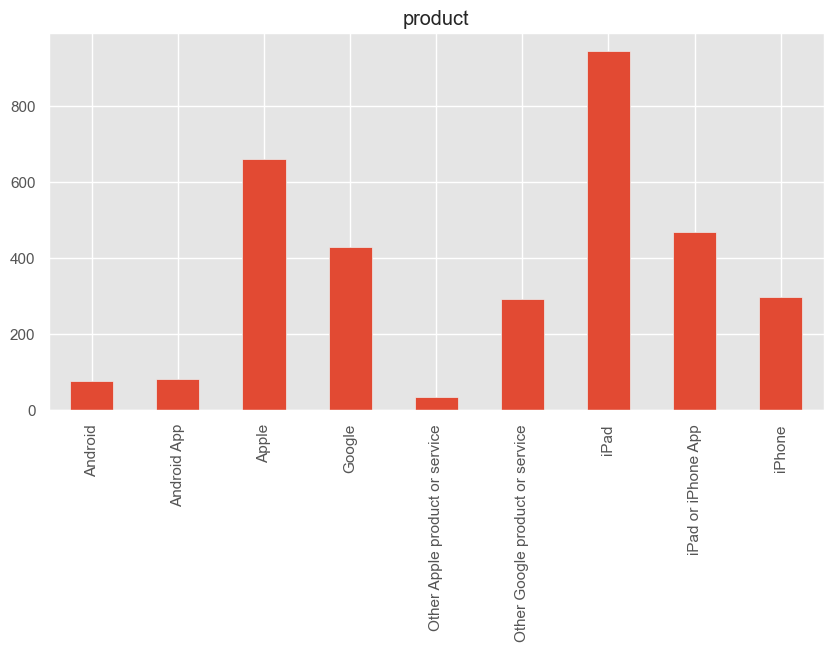

In [13]:
ax = data['product'].value_counts().sort_index() \
    .plot(kind='bar',
         title = 'product',
         figsize=(10,5))

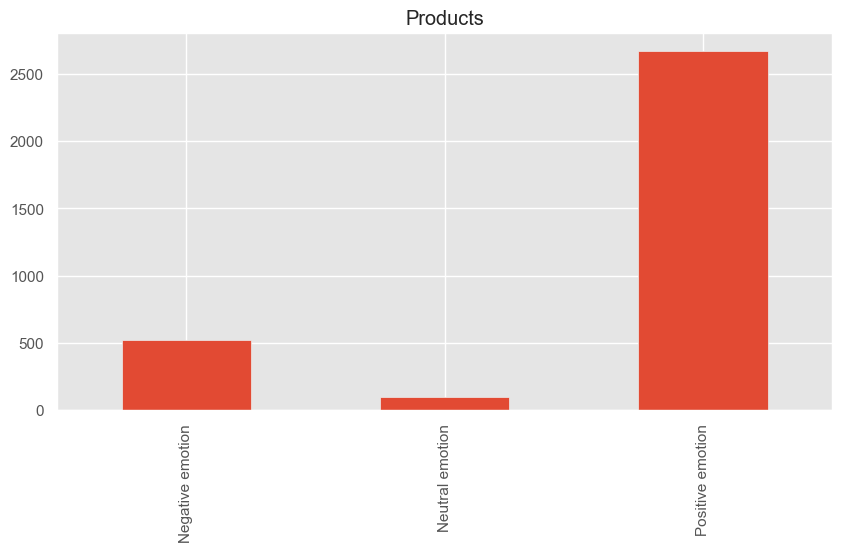

In [14]:
ax = data['sentiment'].value_counts().sort_index() \
    .plot(kind='bar',
         title = 'Products',
         figsize=(10,5))

## Basic NLTK preprocessing

In [15]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [16]:
stop_words.update(['link', 'rt', 'quot', 'amp', 'mention'])

In [17]:
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = tokenizer.tokenize(tweet)
    tweet = [word for word in tweet if word not in stop_words]
    tweet = [stemmer.stem(word) for word in tweet]
    return ' '.join(tweet)

In [18]:
data['preprocessed_tweet'] = data['tweet'].apply(preprocess)

In [19]:
data['preprocessed_tweet']

0       wesley83 3g iphon 3 hrs tweet rise_austin dead...
1       jessede know fludapp awesom ipad iphon app lik...
2                   swonderlin wait ipad 2 also sale sxsw
3        sxsw hope year festiv crashi year iphon app sxsw
4       sxtxstate great stuff fri sxsw marissa mayer g...
                              ...                        
3286    pr guy convinc switch back iphon great sxsw co...
3287          papyrus sort like ipad nice lol sxsw lavell
3288    diller say googl tv might run playstat xbox es...
3289    alway use camera iphon b c imag stabil mode su...
3290                                  ipad everywher sxsw
Name: preprocessed_tweet, Length: 3291, dtype: object

## Model 1

In [20]:
## Make X into a vector
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['preprocessed_tweet'])

In [21]:
## Create my y-axis and Train Test split
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8649468892261002

In [23]:
y_pred = rf.predict(X_test)

## Word Counter

In [24]:
tokens = nltk.word_tokenize(' '.join(data['preprocessed_tweet']))

In [25]:
fdist = nltk.FreqDist(tokens)

In [26]:
print(fdist.most_common(10))

[('sxsw', 3468), ('ipad', 1195), ('appl', 1015), ('googl', 795), ('iphon', 663), ('store', 576), ('2', 551), ('app', 528), ('new', 369), ('austin', 304)]


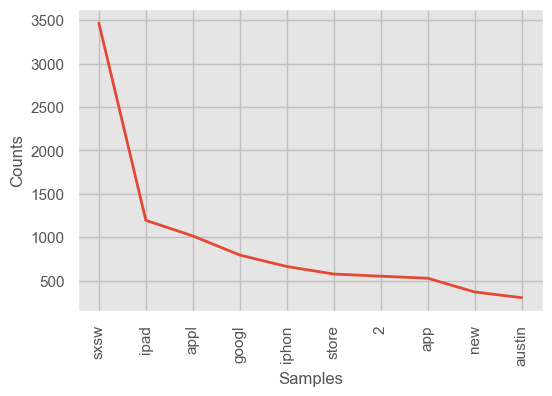

In [27]:
fdist.plot(10, cumulative=False)
plt.show()

## Word play

In [28]:
## New Dataframe to play around with
rq = data.copy()

In [29]:
rq['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [30]:
## Making New dataframe only Apple and Google p
rq['product'] = rq['product'].apply(lambda x: "Google" if (x == "Other Google product or service") \
                                    | (x == "Android App") | (x == "Android") else "Apple")

In [31]:
rq['product'].value_counts()

Apple     2839
Google     452
Name: product, dtype: int64

## Positive vs Negative Apple

In [32]:
## Created new dataframe with Only Apple Products
rq_apple = rq[rq['product'] == "Apple"]

In [33]:
## Positive Sentiment for apple products
p_rq_apple = rq_apple[rq_apple['sentiment'] == "Positive emotion"]

In [34]:
## Negative Sentiment for apple products
n_rq_apple = rq_apple[rq_apple['sentiment'] == "Negative emotion"]

## Word Count Positive Apple Products

In [35]:
tokens = nltk.word_tokenize(' '.join(p_rq_apple['preprocessed_tweet']))

In [36]:
fdist = nltk.FreqDist(tokens)

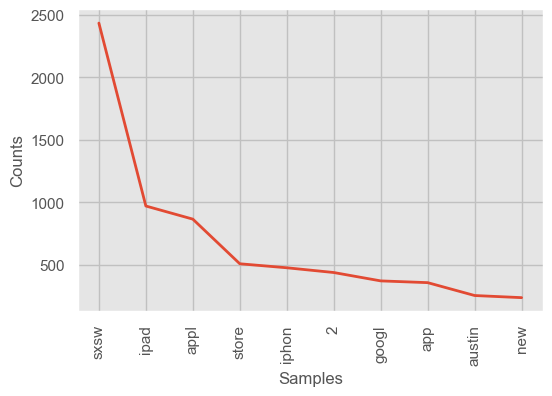

In [37]:
fdist.plot(10, cumulative=False)
plt.show()

## Word Count Negative Apple Products

In [38]:
tokens = nltk.word_tokenize(' '.join(n_rq_apple['preprocessed_tweet']))

In [39]:
fdist = nltk.FreqDist(tokens)

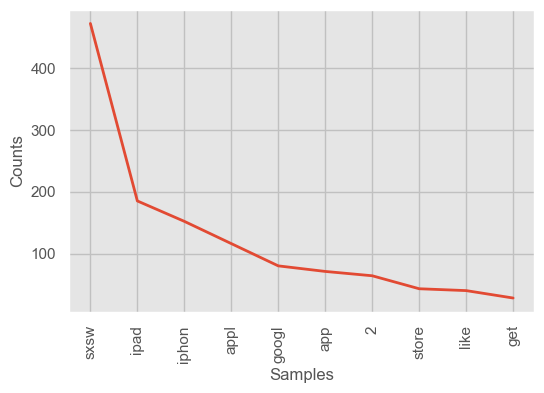

In [40]:
fdist.plot(10, cumulative=False)
plt.show()

## Apple vs Google sentiment

In [41]:
## New copy of the dataframe
rq1 = rq

In [42]:
## Getting rid of Neutral emotion since we are focusing on Positive vs Negative emotion
rq1 = rq1[rq1['sentiment'] != "Neutral emotion"]

In [43]:
## Split the data frame into the main 2 categories Apple vs Google
rq1_google = rq1[rq1['product'] == "Google"]
rq1_apple = rq1[rq1['product'] == "Apple"]

In [44]:
lul = rq1_apple['sentiment'].value_counts(normalize=True)

In [45]:
lol = rq1_google['sentiment'].value_counts(normalize=True)

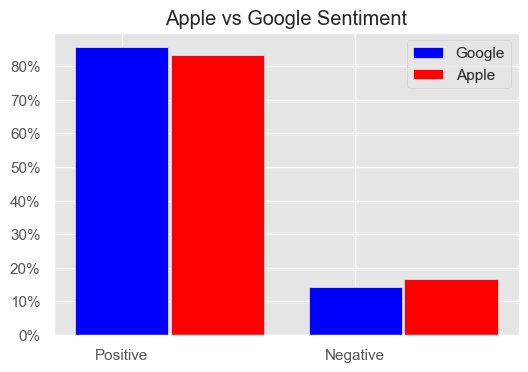

In [46]:
fig, ax = plt.subplots()

ax.bar(x = [0,1], height = lol.values, width=0.4, color='blue')

ax.bar(x = [0.41,1.41], height = lul.values, width=0.4, color='red')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Positive', 'Negative'])
ax.set_title('Apple vs Google Sentiment')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Google', 'Apple'])

plt.show()

# Apple Model

In [64]:
rq_apple = rq[rq['product'] == "Apple"]

In [65]:
vectorizer = CountVectorizer()

X_apple = vectorizer.fit_transform(rq_apple['preprocessed_tweet'])
y_apple = rq_apple['sentiment']

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_apple, y_apple, test_size=0.2, random_state=42)
rfc = RandomForestClassifier(random_state=42)

In [66]:
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.8649468892261002

## Grid Search

In [143]:
param_grid = {
    'n_estimators': [100, 120,140], 
    'max_depth': [60, 70],
    'class_weight': [None, 'balanced']
}

In [144]:
rf_tuned = RandomForestClassifier()

In [145]:
grid_search = GridSearchCV(rf_tuned, param_grid, cv=5)

In [146]:
grid_search.fit(X_train_a, y_train_a)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [60, 70],
                         'n_estimators': [100, 120, 140]})

In [147]:
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'class_weight': 'balanced', 'max_depth': 70, 'n_estimators': 100}
Best score:  0.8520433751270756


In [157]:
## Model after tunning didn't give us a more accurate model, so we are going to keep it as the simple model

rf_tuned = RandomForestClassifier(n_estimators=100, max_depth=70, class_weight='balanced', random_state=42)

In [158]:
rf_tuned

RandomForestClassifier(class_weight='balanced', max_depth=70, random_state=42)

In [159]:
rf_tuned.fit(X_train_a, y_train_a)
rf_tuned.score(X_test_a, y_test_a)

0.8274647887323944